<a href="https://colab.research.google.com/github/zzcn23/ZoeCannprojecr.ipynb/blob/main/Zoe_CannU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project: Making a Generalized Linear Model (1 predictor)




In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

For my project I knew I wanted to look at voting trends, mainly because there's so much voting data out there and I've been seeing a lot of analysis of the 2024 election. For my data, I went through a couple different data sets. I started with voting turnout and income by state, which wasn't enough data points and there also wasn't a strong enough correlation. Eventually, I ended up looking at Texas counties because theres 254 of them. I wanted to analyze how education impacta voting turnout because I saw that there was a correlation in the  2024 election in some articles but wasn't sure if it was present in past elections, or in Texas counties.

My data set consists of voting turnout percentages in each Texas county during the 2020 general election and the percent of the county with bachelors degrees in 2020.

In [3]:
#load the data into a pandas dataframe, and print it
url_vote = 'https://raw.githubusercontent.com/zzcn23/ZoeCannprojecr.ipynb/refs/heads/main/vote.csv'
#I could have put the url string directly into pd.read_csv()
vote = pd.read_csv(url_vote)

In [4]:
vote

,County,Voting,Education,Unnamed: 3
0,ANDERSON,49.32,11.7,NaN
1,ANDREWS,46.11,10.4,NaN
2,ANGELINA,53.80,16.3,NaN
3,ARANSAS,59.55,21.7,NaN
4,ARCHER,55.41,23.4,NaN
...,...,...,...,...
249,WOOD,59.62,16.4,NaN
250,YOAKUM,48.17,16.3,NaN
251,YOUNG,59.58,19.6,NaN
252,ZAPATA,29.15,10.4,NaN


Text(0, 0.5, 'Voting')

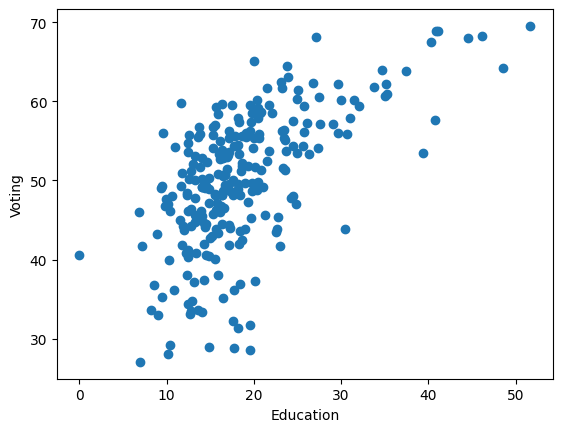

In [4]:
#make scatter plot of FT% and FG% for NBA players form the 23/24 season
plt.scatter(vote['Education'] , vote['Voting'],)

#label axes
plt.xlabel("Education")
plt.ylabel("Voting")

As you can see in the plot, it looks like theres a decent positive correlation between education and voting turnout with a large concentration around 50-60% turnout and 10-20% education. The data does have somewhat of a log shape but I couldn't tell if it was more linear or not.

<Axes: ylabel='Education'>

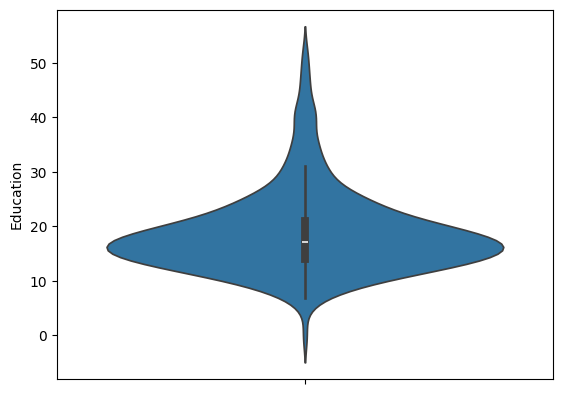

In [5]:
sns.violinplot(vote.Education)

Here's a violin plot to look at the concentration of data

#Take 1

I decided to start by assuming there was a linear relationship. I used a Normal likelihood because its a good first guess and used deterministic for the mean line so it would be linear. My priors were weakly informative and not strong because I wanted to allow for lots of variability

In [68]:
#vt - vote trend
with pm.Model() as model_vote1:

    #priors for linear part
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #mean line- linear
    μ = pm.Deterministic("μ", α + β * vote.Education)

    #prior for the standard deviation
    σ = pm.HalfCauchy("σ", 20)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed= vote.Voting)

    #inference data object
    idata_vt1 = pm.sample()

Output()

Output()

In [69]:
# posterior predictive check
pm.sample_posterior_predictive(idata_vt1, model=model_vote1,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Voting')

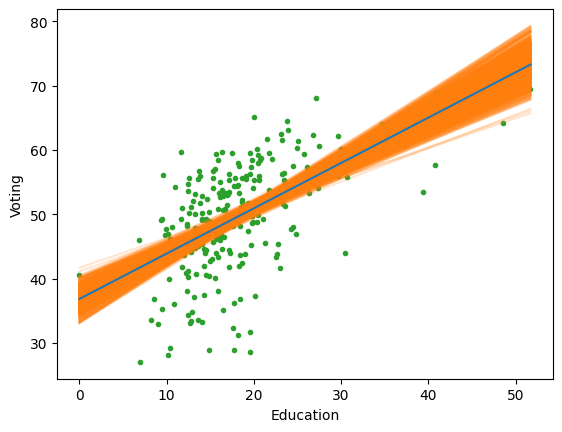

In [93]:
posterior = az.extract(idata_vt1,)

# x values for graphing
x_plot = np.linspace(vote.Education.min(), vote.Education.max(), 50)

# Ensure posterior["α"] and posterior["β"] are reshaped correctly
α_samples = posterior["α"].values[:, None]
β_samples = posterior["β"].values[:, None]

# Expected mean line
mean_line = α_samples.mean() + β_samples.mean() * x_plot

# Multiple lines from posterior
lines = α_samples + β_samples * x_plot

# Set up plot
_, ax = plt.subplots()

# Plot 50 sampled lines
ax.plot(x_plot,lines.T, c="C1", alpha=0.2, label="lines")

# Plot the mean line
ax.plot(x_plot, mean_line, c="C0", label="Mean Line")

# Plot the  data
ax.plot(vote.Education, vote.Voting, "C2.", zorder=-3, label="Raw Data")

# Label axes
ax.set_xlabel("Education")
ax.set_ylabel("Voting")

The mean line sort of captures the data trend but it doesn't account for a lot of the outliers on the bottom and top, it also doesnt capture the slope as well as I wanted. We do see that there is a positive trend in the data between voting and education though

<Axes: xlabel='y_pred'>

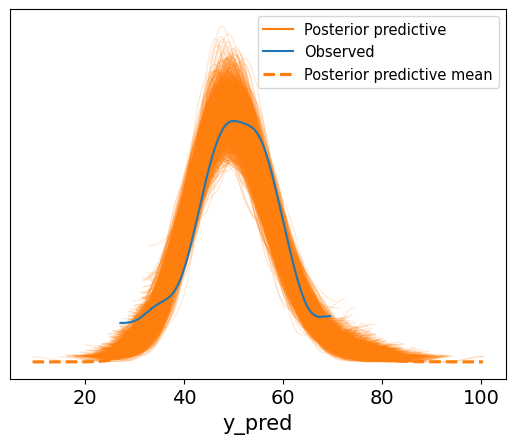

In [94]:
#ANSWER7 cont.

# posterior predictive check
az.plot_ppc(idata_vt1, colors=["C1", "C0", "C1"])

This also looks fine but the mode is slightly off center and the posterior is right skewed so I thought I could do better.

#Take 2

Next I decided to change my mean line to log normal to account for that curve and the data's skewed, positively biased distribution

For my intercept prior (α) I chose mu to be 0 because I didn't think any of the counties would have a population with 0% of bachelors degrees and if they did, the voting turnout would probably be 0 too. I picked sigma to be around 100 because I wanted to allow a wide range of possibilities amoung all the counties.

For the slope prior (β) I chose mu to be around 0 because I wasn't certain if there would be a positive or negative or no slope since I was looking at Texas counties in 2020 and wasn't confident in my knowledge for that specific voting trend. I centered sigma at 20 because I had no idea how strong or weak the trend would be either and wanted to allow for variation

For standard deviation I used deterministic because I was slightly unsure of the datas spread but I did expect the variance to slightly increase as education increased. I wanted to directly tye the variability to the predictors because I know it leads to a more stable and identifiable model and when I used other standard deviations the model didn't work as well and had a ton of divergences.

In [89]:
#vt - vote trend
with pm.Model() as model_vote:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=20)

    #mean line
    μ = pm.LogNormal("μ", α + β * vote.Education)

   # Deterministic standard deviation
    σ = pm.Deterministic("σ", α + β * vote.Education)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed= vote.Voting)

    #inference data object
    idata_vt = pm.sample()

Output()

Output()

In [90]:
# posterior predictive check
pm.sample_posterior_predictive(idata_vt, model=model_vote,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Voting')

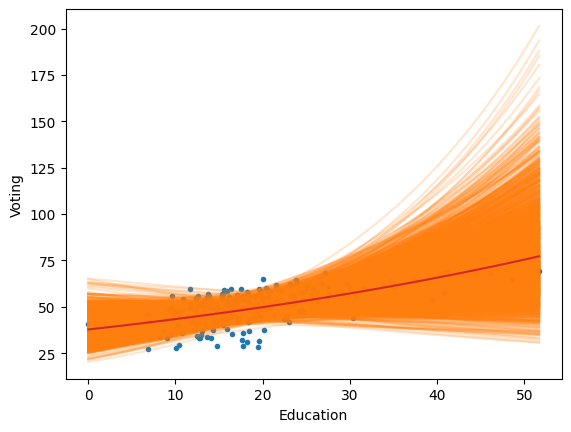

In [91]:
posterior = az.extract(idata_vt)

# x values for graphing
x_plot = np.linspace(vote.Education.min(), vote.Education.max(), 50)

# Ensure posterior["α"] and posterior["β"] are reshaped correctly
α_samples = posterior["α"].values[:, None]
β_samples = posterior["β"].values[:, None]

# Expected mean line
mean_line = α_samples.mean() + β_samples.mean() * x_plot

# Multiple lines from posterior
lines = α_samples + β_samples * x_plot

# Set up plot
_, ax = plt.subplots()

# Plot 50 sampled lines
ax.plot(x_plot, np.exp(lines.T), c="C1", alpha=0.2, label="lines")

# Plot the mean line
ax.plot(x_plot, np.exp(mean_line), c="C3", label="Mean Line")

# Plot the  data
ax.plot(vote.Education, vote.Voting, "C0.", zorder=-3, label="Raw Data")

# Label axes
ax.set_xlabel("Education")
ax.set_ylabel("Voting")

This looks a lot better, more variance and accounts for more of that data with a better trendline, the variance spreads out more than needed but changing the standard deviation to account for more variability didn't work out better than this. The slope of the mean line is a little less step than the last one but theres still a positive trend in the data

<Axes: xlabel='y_pred'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


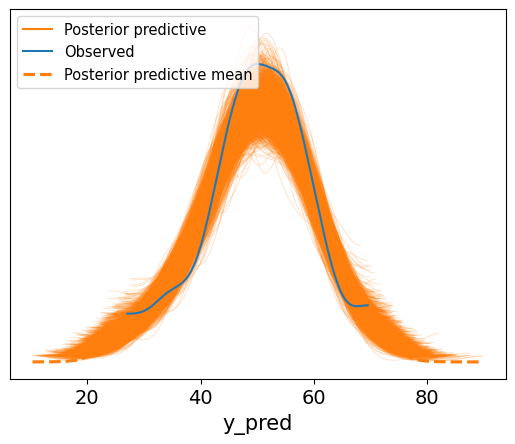

In [92]:
#ANSWER7 cont.
# posterior predictive check
az.plot_ppc(idata_vt, colors=["C1", "C0", "C1"])

This posterior looks better, the mode is centered more and and all the data falls within the posterior. The posterior underestimates a little bit but after messing with a lot of different priors and and values, this is pretty solid. It shows us that the average voting turnout percentage is around 50% but can range from under 20% to 80% which I think is accurate.

Overall, I learned that there is a positive correlation between voting and higher education levels in Texas counties in the 2020 election, and that the trend is better accounted for using a log as opposed to a linear mean line. I think that this makes a lot of sense because college education is popular across America, and it would be rare to have an entire county with no college education, so the curve on the graph starts at around 10% on the x-axis. There's also a steeper slope at lower education levels.

If I did this again, I would try to account for different variables that were impacting the voting turnout besides education and look at them at the same time to compare impacts and trends.